# Analysis of tblCardData

This notebook contains codes and functions to run queries to analyze and understand the data present in the table `tblCardData` of the xspoc database.

In [1]:
"""
For setting up local imports in an Ipython Shell
This is a workaround for ipython, dont need it for basic python scripts
"""
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import struct
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Project Library
from library.dbconnection import PostgresRDS
from library.sqlFunctions import run_query
from library.cardFunctions import Cleaning

In [3]:
"""
Dyna Functions
Note: Once Testing done will be moved to the cardFunctions library
"""
# Converting to Polygon
def hex_to_poly(card):
    xy = Cleaning.get_dyna(card)
    try:
        poly = Polygon(xy)
    except Exception as e:
        print(e)
        poly = np.nan
    
    return poly

# Plotting
def dyna_plot(card, name, fill=True, color='k', set_axis=None, save=None, show=True):
    xy = np.asarray(card.exterior.coords)
    pos_clean = xy[:, 0] 
    load_clean = xy[:, 1]

    fig_clean, ax_clean = plt.subplots()

    if fill:
        ax_clean.fill(pos_clean, load_clean, facecolor=color, alpha=1)
    else:
        ax_clean.plot(pos_clean, load_clean, c=color, alpha=1)

    if set_axis:
        ax_clean.set_ylim(set_axis)

#     plt.axis('off')
    fig_clean.set_size_inches(12, 8)

    if show:
        plt.show()

    if save:
        save_name = os.path.join(save, name + ".png")
        plt.savefig(save_name, dpi=50, bbox_inches='tight')

    plt.close()

## Queries

Uee the `run_query` functions to run queries. Check `Analysis.md` for some examples.

In [4]:
%%time
# Some Exploratory Queries

cols_query = """
SELECT attname            AS col
     , atttypid::regtype  AS datatype
       -- more attributes?
FROM   pg_attribute
WHERE  attrelid = 'xspoc_dbo."tblCardData"'::regclass  -- table name, optionally schema-qualified
AND    attnum > 0
AND    NOT attisdropped
ORDER  BY attnum;
"""

well_query = """
SELECT DISTINCT("NodeID")
FROM xspoc_dbo."tblCardData"
ORDER BY "NodeID"
"""

with PostgresRDS(db='oasis-data') as engine:
    col_list_full = run_query(cols_query, engine)  # Profiling: 1s 680ms -- Will be longer in jupyter
    well_list_full = run_query(well_query, engine)  # Profiling: 1m 10s -- Longer in jupyter

Connected to oasis-data DataBase
Connection Closed
Wall time: 1min 36s


In [5]:
print("List of Columns")
display(col_list_full)

List of Columns


,col,datatype
0,NodeID,character varying
1,Date,timestamp without time zone
2,CardType,character varying
3,SurfaceCard,text
4,SPM,real
5,StrokeLength,integer
6,Runtime,real
7,LoadLimit,integer
8,PositionLimit,integer
9,DownholeCard,text


In [6]:
print('\n list of wells')
display(well_list_full)


 list of wells


,NodeID
0,Aagvik 1-35H
1,ACADIA 31-25H
2,Acklins 12-18H
3,Aerabelle 5502 43-7T
4,A. JOHNSON 12-1H
...,...
900,YEISER 5603 42-33H
901,Yukon 41-12T
902,Zaye Federal 34-2H
903,Zdenek 6093 42-24H


## Well Specific

**Note:**
While specifying card based columns (bytea). Query the column as follows

```
encode("tblCardData"."ActualCardCol", 'hex') as <specifyanewname>
# eg:
encode("tblCardData"."DownholeCardB", 'hex') as downcard
```

In the variable `card_cols`, have a list of these card columns being used. For eg.
```
# Say we are QUerying 'DownholeCardB' and 'SurfaceCardB', query will look something like this

encode("tblCardData"."DownholeCardB", 'hex') as downcard,
encode("tblCardData"."SurfaceCardB", 'hex') as surfcard,

# In the python scipt
card_cols = ['downcard', 'surfcard']
```

In [7]:
well_name = 'Cook 12-13 7T'
card_cols = ['downcard', 'surfcard']

query = """
SELECT 
"NodeID",
"Date",
encode("tblCardData"."POCDownholeCardB", 'hex') as downcard,
encode("tblCardData"."SurfaceCardB", 'hex') as surfcard,  -- Add more column if need be
"Area",
"LoadLimit"
FROM xspoc_dbo."tblCardData"
WHERE "NodeID" = '{}'
ORDER BY "NodeID" , "Date";
""".format(well_name)

with PostgresRDS(db='oasis-data') as engine:
    well_data = run_query(query, engine)

for c in card_cols:
    well_data.loc[:, c] = well_data.loc[:, c].apply(hex_to_poly)
    
display(well_data.head())

Connected to oasis-data DataBase
Connection Closed


,NodeID,Date,downcard,surfcard,Area,LoadLimit
0,Cook 12-13 7T,2019-04-22 07:39:11,"POLYGON ((9.050000190734863 -10033, 21.4799995...","POLYGON ((0.4199999868869781 24539, 0.88999998...",4,141
1,Cook 12-13 7T,2019-04-23 07:46:16,"POLYGON ((7.079999923706055 -9557, 18.57999992...","POLYGON ((0.4199999868869781 24906, 0.81000000...",4,147
2,Cook 12-13 7T,2019-04-23 10:09:32,"POLYGON ((7.420000076293945 -9915, 19.22999954...","POLYGON ((0.3899999856948853 24685, 0.87000000...",4,145
3,Cook 12-13 7T,2019-04-23 14:13:09,"POLYGON ((11.02000045776367 -9829, 21.69000053...","POLYGON ((0.4600000083446503 24304, 0.93000000...",4,156
4,Cook 12-13 7T,2019-04-23 14:27:49,"POLYGON ((8.449999809265137 -10079, 17.8899993...","POLYGON ((0.7799999713897705 22912, 1.25999999...",4,185


Example Row

NodeID                                           Cook 12-13 7T
Date                                       2019-05-01 01:58:56
downcard     POLYGON ((7.710000038146973 -8925, 18.95999908...
surfcard     POLYGON ((0.4000000059604645 24444, 0.79000002...
Area                                                         4
LoadLimit                                                  149
Name: 56, dtype: object


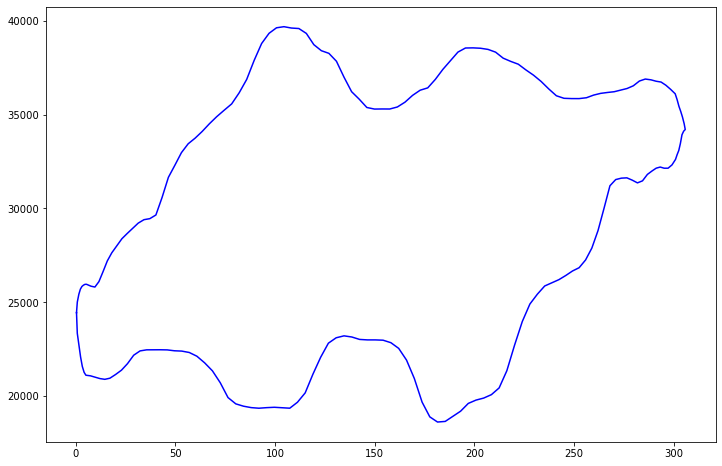

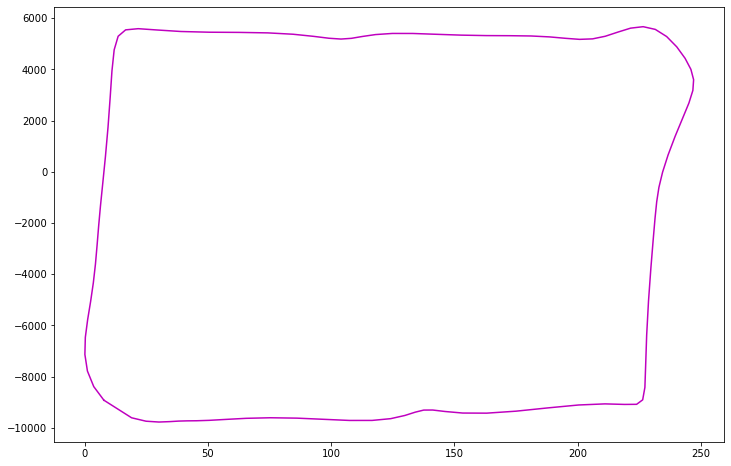

In [8]:
# Plot some examples
row = 56
print("Example Row\n")
print(well_data.loc[row])

test_surf = well_data.loc[row, 'surfcard']
dyna_plot(test_surf, 'test_downcard', fill=False, color='b', set_axis=None, save=None, show=True)

test_down = well_data.loc[row, 'downcard']
dyna_plot(test_down, 'test_downcard', fill=False, color='m', set_axis=None, save=None, show=True)

## Query a list of wells

In [9]:
%%time
# Add wells to the list
well_list = [
    'Bonner 9-12H',
    'Bonner 9X-12HA',
    'Bonner 9X-12HB'
]

card_cols = ['downcard', 'surfcard']

query = """
select 
"NodeID",
"Date",
encode("tblCardData"."POCDownholeCardB", 'hex') as downcard,
encode("tblCardData"."SurfaceCardB", 'hex') as surfcard,
"CardArea",
"StrokeLength"               -- Add or delete columns
from xspoc_dbo."tblCardData"
where "NodeID" in {}
order by "NodeID", "Date"
""".format(tuple(well_list))

with PostgresRDS(db='oasis-data') as engine:
    data = run_query(query, engine)

for c in card_cols:
    data.loc[:, c] = data.loc[:, c].apply(hex_to_poly)
    
display(data.head())
print("Wells Present")
display(data.NodeID.unique())

Connected to oasis-data DataBase
Connection Closed


,NodeID,Date,downcard,surfcard,CardArea,StrokeLength
0,Bonner 9-12H,2019-01-22 13:30:13,"POLYGON ((10.10000038146973 -8889, 25.12000083...","POLYGON ((0.6100000143051147 22700, 1.23000001...",0,306
1,Bonner 9-12H,2019-03-19 00:51:53,"POLYGON ((6.53000020980835 -8826, 21.870000839...","POLYGON ((0.6100000143051147 22578, 1.23000001...",0,306
2,Bonner 9-12H,2019-03-19 02:41:29,"POLYGON ((10.06999969482422 -8892, 22.12999916...","POLYGON ((0.6100000143051147 22700, 1.23000001...",0,306
3,Bonner 9-12H,2019-03-19 04:57:34,"POLYGON ((4.639999866485596 -9044, 17.45000076...","POLYGON ((0.6100000143051147 22116, 1.23000001...",0,306
4,Bonner 9-12H,2019-03-19 06:41:44,"POLYGON ((6.300000190734863 -8971, 15.34000015...","POLYGON ((0.6100000143051147 21344, 1.23000001...",0,306


Wells Present


array(['Bonner 9-12H', 'Bonner 9X-12HA', 'Bonner 9X-12HB'], dtype=object)

Wall time: 44.9 s


Example Row

NodeID                                             Bonner 9X-12HB
Date                                          2019-03-24 23:06:40
downcard        POLYGON ((8.430000305175781 -8799, 15.59000015...
surfcard        POLYGON ((0.4600000083446503 21106, 0.92000001...
CardArea                                                        0
StrokeLength                                                  306
Name: 5678, dtype: object


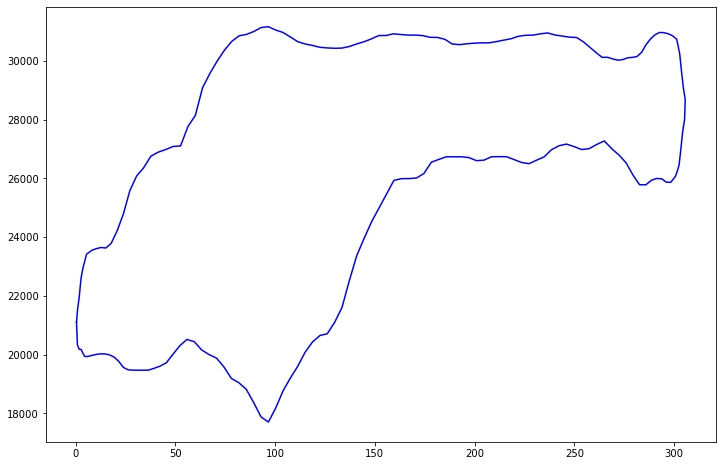

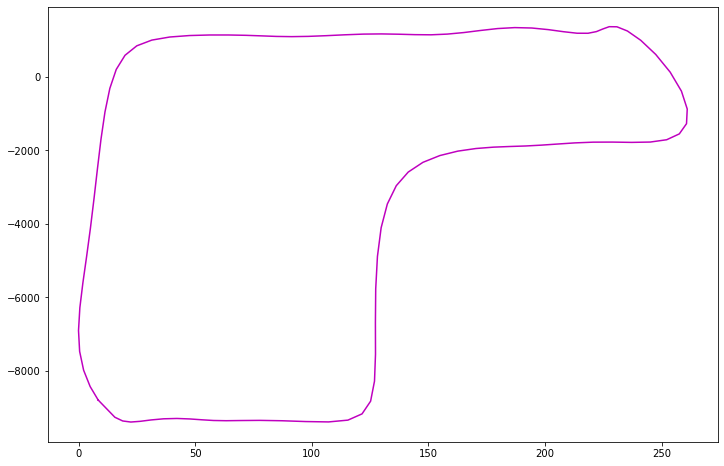

In [10]:
# Plot some examples
row = 5678
print("Example Row\n")
print(data.loc[row])

test_surf = data.loc[row, 'surfcard']
dyna_plot(test_surf, 'test_downcard', fill=False, color='b', set_axis=None, save=None, show=True)

test_down = data.loc[row, 'downcard']
dyna_plot(test_down, 'test_downcard', fill=False, color='m', set_axis=None, save=None, show=True)